# 🧪 EDA con PySpark - Comportamiento de Usuarios en eCommerce

Este cuaderno utiliza PySpark para realizar un análisis exploratorio de datos (EDA) sobre el archivo `2020-Apr.csv.gz`. Evaluaremos la calidad del dataset, incluyendo valores nulos, duplicados, y formatos erróneos, y documentaremos los pasos necesarios para su limpieza.

## 1.📥 Carga de librerías y creación de sesión de Spark

In [73]:
# Importamos PySpark y funciones necesarias
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, isnan, udf, hour, to_date
from pyspark.sql.types import TimestampType
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Creamos una sesión de Spark para el análisis
spark = SparkSession.builder \
    .appName("EDA_Advanced_eCommerce") \
    .getOrCreate()

## 2.📂 Carga del conjunto de datos

In [3]:
# Cargamos el archivo CSV comprimido, indicando encabezado y tipos inferidos
df_full  = spark.read.csv("../data/raw/2020-Apr.csv.gz", header=True, inferSchema=True)

# Visualizamos el esquema del dataset
df_full .printSchema()

# Mostramos las primeras filas como vista rápida
df_full .show(5)

root
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: long (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)

+-------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|         event_time|event_type|product_id|        category_id|       category_code|   brand|  price|  user_id|        user_session|
+-------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|2020-03-31 19:00:00|      view|   1201465|2232732101407408685|apparel.shoes.sli...| samsung| 230.38|568984877|e2456cef-2d4f-42b...|
|2020-03-31 19:00:01|      view|   1307156|2053013554658804075|electronics.audio...|   a

## 3.📉 Muestreo para el EDA

In [5]:
# Por rendimiento, tomamos una muestra de aproximadamente 1.5 millones de registros
df = df_full.sample(withReplacement=False, fraction=0.023, seed=42)

print(f"Total registros muestreados: {df.count()}")

Total registros muestreados: 1531767


In [6]:
# Eliminar DataFrames temporales para liberar memoria
del df_full

## 4.📏 Verificación de dimensiones y estructura

In [8]:
# Verificar dimensiones
print(f"Número de registros: {df.count()}")
print(f"Número de columnas: {len(df.columns)}")
print("Columnas disponibles:", df.columns)

# Visualización del esquema
df.printSchema()

# Vista rápida de los primeros registros
df.show(5)

Número de registros: 1531767
Número de columnas: 9
Columnas disponibles: ['event_time', 'event_type', 'product_id', 'category_id', 'category_code', 'brand', 'price', 'user_id', 'user_session']
root
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: long (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)

+-------------------+----------+----------+-------------------+--------------------+------+-------+---------+--------------------+
|         event_time|event_type|product_id|        category_id|       category_code| brand|  price|  user_id|        user_session|
+-------------------+----------+----------+-------------------+--------------------+------+-------+---------+--------------------+
|2020-03-31 19:00:11|      view|  

## 5. 💵 Estadísticas Generales de Precio

In [10]:
# Estadísticas descriptivas de la columna price
df.describe(["price"]).show()

+-------+-----------------+
|summary|            price|
+-------+-----------------+
|  count|          1531767|
|   mean|273.1112123382352|
| stddev|356.1319784746374|
|    min|              0.0|
|    max|          2574.07|
+-------+-----------------+



## 6. 🚨 Análisis de calidad de datos

### 📌 A. Conteo de valores nulos por columna

In [12]:
# Determinar los tipos de las columnas para aplicar isnan() solo a numéricas
nulos = []
for c in df.columns:
    tipo = dict(df.dtypes)[c]
    if tipo in ['double', 'float']:
        nulos.append(count(when(col(c).isNull() | isnan(c), c)).alias(c))
    else:
        nulos.append(count(when(col(c).isNull(), c)).alias(c))

# Mostrar resultado
df.select(nulos).show(truncate=False)

+----------+----------+----------+-----------+-------------+------+-----+-------+------------+
|event_time|event_type|product_id|category_id|category_code|brand |price|user_id|user_session|
+----------+----------+----------+-----------+-------------+------+-----+-------+------------+
|0         |0         |0         |0          |155385       |205961|0    |0      |2           |
+----------+----------+----------+-----------+-------------+------+-----+-------+------------+



### 📌 B. Verificación de duplicados

In [19]:
# Comparar conteo total con registros únicos
total_registros = df.count()
registros_sin_duplicados = df.dropDuplicates().count()
duplicados = total_registros - registros_sin_duplicados

print(f"🔁 Duplicados detectados: {duplicados}")

🔁 Duplicados detectados: 148


### 📌 C. Conteo de valores únicos por columna

In [20]:
# Recuento de valores únicos por columna
for columna in df.columns:
    print(f"🔍 Valores únicos en '{columna}': {df.select(columna).distinct().count()}")

🔍 Valores únicos en 'event_time': 1085863
🔍 Valores únicos en 'event_type': 3
🔍 Valores únicos en 'product_id': 124922
🔍 Valores únicos en 'category_id': 1082
🔍 Valores únicos en 'category_code': 139
🔍 Valores únicos en 'brand': 3661
🔍 Valores únicos en 'price': 37111
🔍 Valores únicos en 'user_id': 892389
🔍 Valores únicos en 'user_session': 1281641


### 📌 D. Distribución de tipos de eventos

In [22]:
# Conteo de cada tipo de evento
df.groupBy("event_type").count().orderBy("count", ascending=False).show()

+----------+-------+
|event_type|  count|
+----------+-------+
|      view|1434849|
|      cart|  74880|
|  purchase|  22038|
+----------+-------+



## 7. ⏱️ Enriquecimiento Temporal

In [33]:
# ⏳ Convertir event_time a timestamp y derivar hora y fecha
df = df.withColumn("event_time", col("event_time").cast(TimestampType()))
df = df.withColumn("hour", hour(col("event_time")))
df = df.withColumn("date", to_date(col("event_time")))

## 8. 📈 Visualizaciones

### 📅 Total de eventos por día

C:\Users\ALEJANDRA HINCAPIE\AppData\Local\Temp\ipykernel_21316\1423093388.py:10: UserWarning:

Glyph 128197 (\N{CALENDAR}) missing from current font.

C:\Users\ALEJANDRA HINCAPIE\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128197 (\N{CALENDAR}) missing from current font.



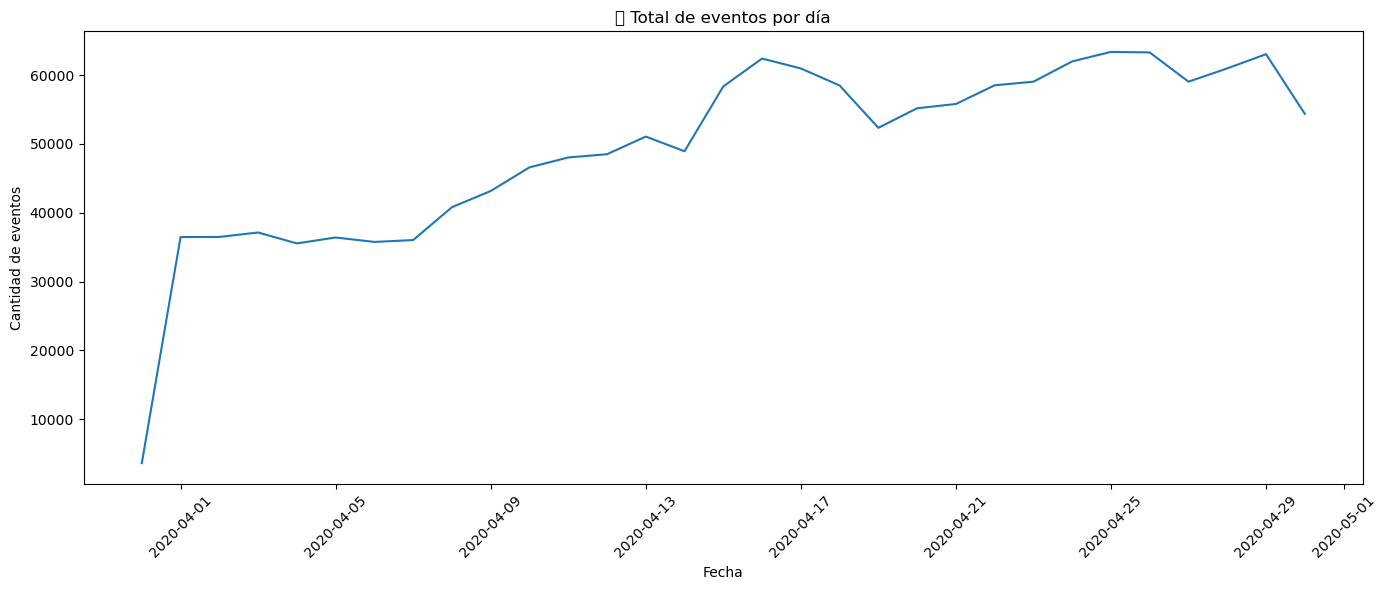

In [61]:
# Convertimos a Pandas para graficar
df_events_day = df.groupBy("date").count().orderBy("date").toPandas()

plt.figure(figsize=(14,6))
sns.lineplot(data=df_events_day, x="date", y="count")
plt.title("📅 Total de eventos por día")
plt.xlabel("Fecha")
plt.ylabel("Cantidad de eventos")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 🕒 Eventos por Hora

C:\Users\ALEJANDRA HINCAPIE\AppData\Local\Temp\ipykernel_21316\3378919100.py:10: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\ALEJANDRA HINCAPIE\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


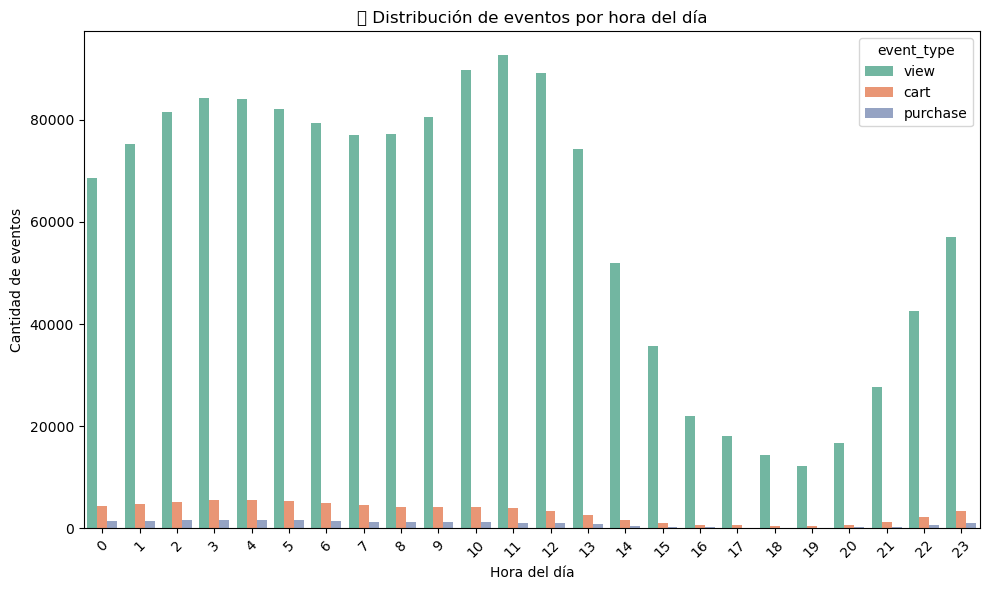

In [41]:
# Convertimos a Pandas para graficar
df_event_hour = df.select("event_type", "hour").toPandas()

plt.figure(figsize=(10,6))
sns.countplot(data=df_event_hour, x="hour", hue="event_type", palette="Set2")
plt.title("📊 Distribución de eventos por hora del día")
plt.xlabel("Hora del día")
plt.ylabel("Cantidad de eventos")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 📊 Distribución de eventos por tipo

C:\Users\ALEJANDRA HINCAPIE\AppData\Local\Temp\ipykernel_21316\3181801342.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\ALEJANDRA HINCAPIE\AppData\Local\Temp\ipykernel_21316\3181801342.py:9: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from current font.

C:\Users\ALEJANDRA HINCAPIE\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from current font.



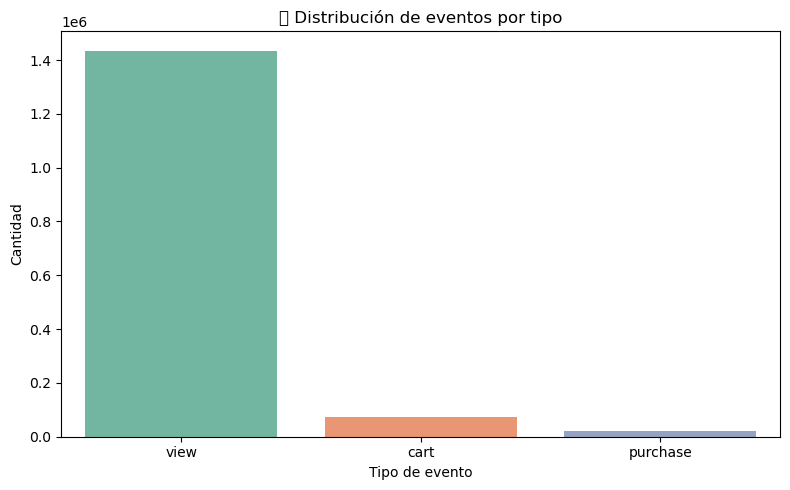

In [52]:
# Convertimos a Pandas para graficar
df_eventos = df.select(["event_type"]).toPandas()

plt.figure(figsize=(8, 5))
sns.countplot(data=df_eventos, x="event_type", palette="Set2")
plt.title("📊 Distribución de eventos por tipo")
plt.xlabel("Tipo de evento")
plt.ylabel("Cantidad")
plt.tight_layout()
plt.show()

### 🔻 Embudo de conversión: Vista → Carrito → Compra

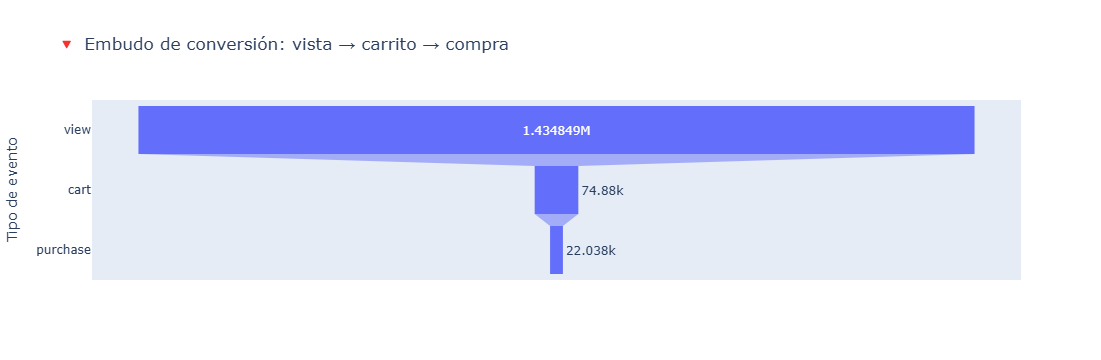

In [55]:
# Convertimos a Pandas para graficar
df_funnel = df.groupBy("event_type").count().toPandas().sort_values("count", ascending=False)

fig = px.funnel(df_funnel, x="count", y="event_type", 
                title="🔻 Embudo de conversión: vista → carrito → compra",
                labels={"event_type": "Tipo de evento", "count": "Cantidad"})
fig.show()

### 🎯 Tasa de sesiones con compra

In [66]:
# Convertimos a Pandas
df_sessions = df.select("user_session", "event_type").toPandas()
df_sessions["compró"] = df_sessions["event_type"] == "purchase"
conversion_rate = df_sessions.groupby("user_session")["compró"].any().mean()

print(f"🎯 Tasa de sesiones con al menos una compra: {conversion_rate * 100:.2f}%")

🎯 Tasa de sesiones con al menos una compra: 1.71%


### 💸 Análisis de precios

📊 Estadísticas de precio:
count    1.531767e+06
mean     2.731112e+02
std      3.561320e+02
min      0.000000e+00
25%      5.146000e+01
50%      1.487800e+02
75%      3.420900e+02
max      2.574070e+03
Name: price, dtype: float64


C:\Users\ALEJANDRA HINCAPIE\AppData\Local\Temp\ipykernel_21316\3788187558.py:14: UserWarning:

Glyph 128184 (\N{MONEY WITH WINGS}) missing from current font.

C:\Users\ALEJANDRA HINCAPIE\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128184 (\N{MONEY WITH WINGS}) missing from current font.



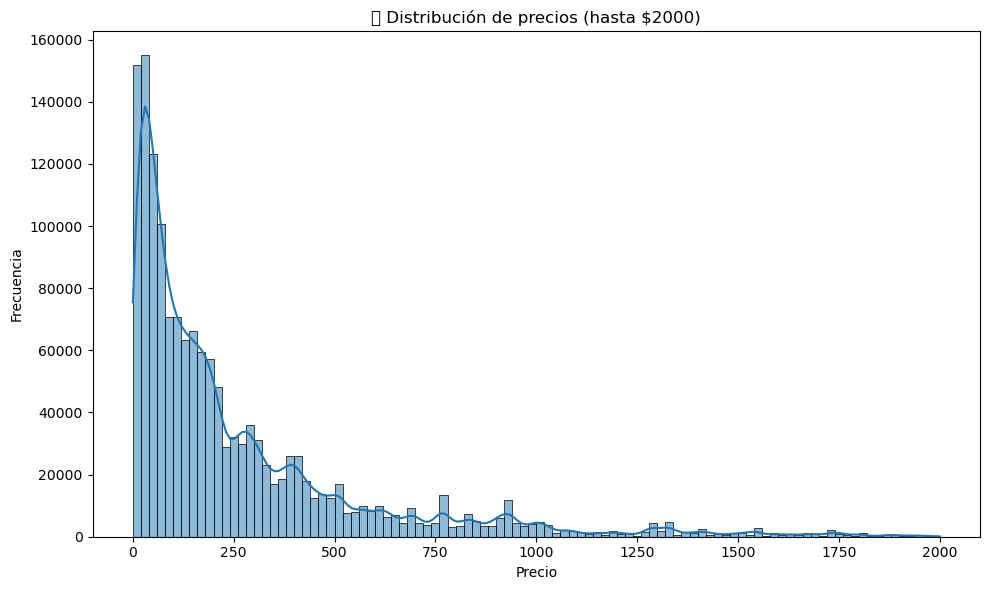

In [68]:
# Convertimos a Pandas para graficar
df_price = df.select("price").toPandas()

print("📊 Estadísticas de precio:")
print(df_price["price"].describe())

df_price_viz = df_price[df_price["price"] < 2000]

plt.figure(figsize=(10,6))
sns.histplot(df_price_viz["price"], bins=100, kde=True)
plt.title("💸 Distribución de precios (hasta $2000)")
plt.xlabel("Precio")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

### 🚨 Detección de Outliers de Precio (IQR)

In [70]:
Q1 = df_price["price"].quantile(0.25)
Q3 = df_price["price"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df_price[(df_price["price"] < lower_bound) | (df_price["price"] > upper_bound)]
print(f"🚨 Outliers detectados: {len(outliers):,}")
print(f"🔼 Límite superior: {upper_bound:.2f}")
print(f"🔽 Límite inferior: {lower_bound:.2f}")

🚨 Outliers detectados: 126,686
🔼 Límite superior: 778.03
🔽 Límite inferior: -384.49


### 🏷️ Marcas más frecuentes por tipo de evento

C:\Users\ALEJANDRA HINCAPIE\AppData\Local\Temp\ipykernel_21316\2731178576.py:11: UserWarning:

Glyph 127991 (\N{LABEL}) missing from current font.

C:\Users\ALEJANDRA HINCAPIE\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 127991 (\N{LABEL}) missing from current font.



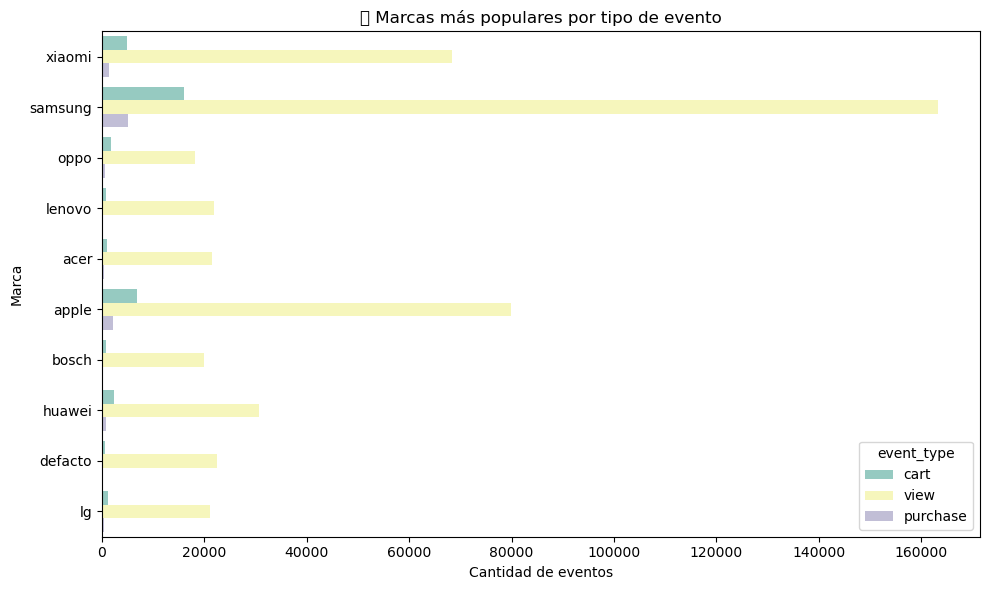

In [72]:
# Convertimos a Pandas para graficar
df_marcas = df.select("event_type", "brand").dropna().toPandas()
top_brands = df_marcas["brand"].value_counts().head(10).index
df_top_brands = df_marcas[df_marcas["brand"].isin(top_brands)]

plt.figure(figsize=(10,6))
sns.countplot(data=df_top_brands, y="brand", hue="event_type", palette="Set3")
plt.title("🏷️ Marcas más populares por tipo de evento")
plt.xlabel("Cantidad de eventos")
plt.ylabel("Marca")
plt.tight_layout()
plt.show()